In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima


In [2]:
df=pd.read_csv('Kiriwaneliya_project.csv')
df.head()


,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,104.699999,11.0,20.2,NaN,NaN
1,2010,February,34.600000,12.0,22.1,NaN,NaN
2,2010,March,128.300001,11.5,23.0,NaN,NaN
3,2010,April,153.200000,13.1,22.5,NaN,NaN
4,2010,May,174.300002,14.1,21.7,NaN,NaN


In [3]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)



In [4]:
#Creating time column
df['Time'] = pd.to_datetime(df['Time'])


In [5]:
df.head()

,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,104.699999,11.0,20.2,NaN,NaN,2010-01-01
1,2010,February,34.600000,12.0,22.1,NaN,NaN,2010-02-01
2,2010,March,128.300001,11.5,23.0,NaN,NaN,2010-03-01
3,2010,April,153.200000,13.1,22.5,NaN,NaN,2010-04-01
4,2010,May,174.300002,14.1,21.7,NaN,NaN,2010-05-01


In [6]:
rainfall=df[["Time","Rainfall"]]
rainfall.head()

,Time,Rainfall
0,2010-01-01,104.699999
1,2010-02-01,34.600000
2,2010-03-01,128.300001
3,2010-04-01,153.200000
4,2010-05-01,174.300002


In [7]:
#Checking for missing values
rainfall.isna().sum()

Time        0
Rainfall    7
dtype: int64

In [8]:
#Setting the time index
rainfall.set_index('Time',inplace=True)

In [9]:
rainfall=rainfall.resample('MS').first()

In [10]:
#removing missing values
rain=rainfall.fillna(method='ffill')
rain.head(20)



,Rainfall
Time,
2010-01-01,104.699999
2010-02-01,34.600000
2010-03-01,128.300001
2010-04-01,153.200000
2010-05-01,174.300002
2010-06-01,270.200001
2010-07-01,170.200000
2010-08-01,196.300000
2010-09-01,180.600002


In [11]:
#Checking for missing values
rain.isna().sum()

Rainfall    0
dtype: int64

<AxesSubplot:xlabel='Time'>

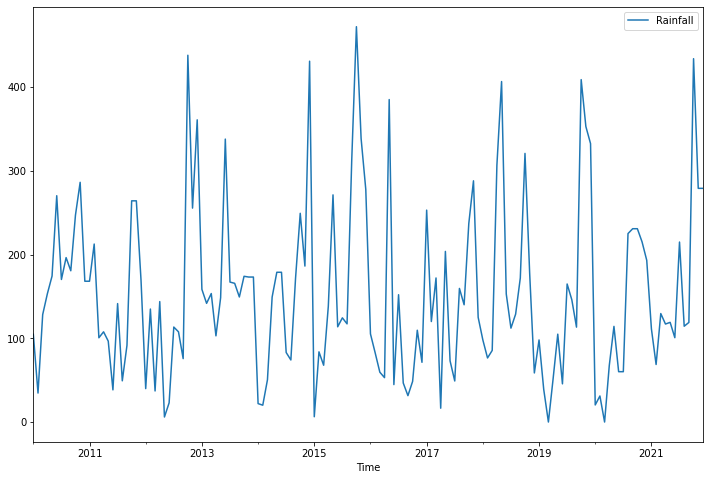

In [12]:
rain.plot(figsize=(12,8))

No significant trend. But it can be seen that there is some evidence for seasonality.

# Testing For Stationarity

In [13]:
### ADF Test
test_result=adfuller(rain['Rainfall'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(rainfall):
    result=adfuller(rainfall)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(rain['Rainfall'])

ADF Test Statistic : -3.5966645589630044
p-value : 0.005825115326645331
#Lags Used : 12
Number of Observations Used : 131
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [14]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(rain['Rainfall'])

KPSS Statistic: 0.049278639307745606
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [15]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(rain['Rainfall'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.655
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

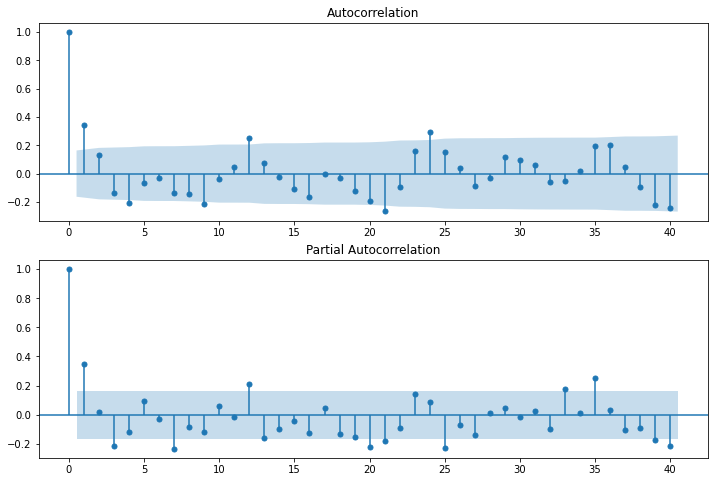

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(rain['Rainfall'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(rain['Rainfall'],lags=40,ax=ax2)

#According to PACF and ACF plots, p=4 d=0 and q=4 is better to start with.

In [26]:
arima_model=auto_arima(rain['Rainfall'].astype(float),start_p=0,start_d=0,start_q=0,max_p=4,max_D=1,max_q=4,start_P=0,start_D=0,start_Q=0,max_P=4,max_Q=4,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=70,maxiter=70)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1748.753, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1744.112, Time=0.13 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1738.292, Time=0.30 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=1736.732, Time=0.70 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=1736.910, Time=1.42 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1740.655, Time=0.27 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1720.845, Time=1.14 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=1725.482, Time=3.19 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=1738.882, Time=1.62 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1732.777, Time=0.53 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1721.311, Time=1.05 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=3.52 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=1730.716, Time=1.24 sec
 ARIMA(0,0

In [27]:
model=sm.tsa.statespace.SARIMAX(rain['Rainfall'].astype('float'),order=(0, 0, 3),seasonal_order=(1,0,1,12))
results=model.fit()
results.summary()

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Rainfall   No. Observations:                  144
Model:             SARIMAX(0, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -856.804
Date:                              Tue, 26 Apr 2022   AIC                           1725.607
Time:                                      02:12:49   BIC                           1743.426
Sample:                                  01-01-2010   HQIC                          1732.848
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2910      0.080      3.638      0.000       0.134       0.448
ma.L2          0.2793      0.113      2.464      0.014       0.057       0.502
ma.L3          0.1073      0.085      1.264      0.206      -0.059       0.274
ar.S.L12       0.9995      0.009    105.505      0.000       0.981       1.018
ma.S.L12      -0.9614      0.379     -2.539      0.011      -1.703      -0.219
sigma2      6948.8939   2346.225      2.962      0.003    2350.378    1.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 8.82
Prob(Q):                              0.74   Prob(JB):                         0.01
Heteroskedasticity (H):               1.06   Skew:                             0.57
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
beg_dt='2018-01-01'
end_dt='2025-12-01'

In [ ]:
#results.predict(start=beg_dt,end=end_dt,dynamic=True)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time'>

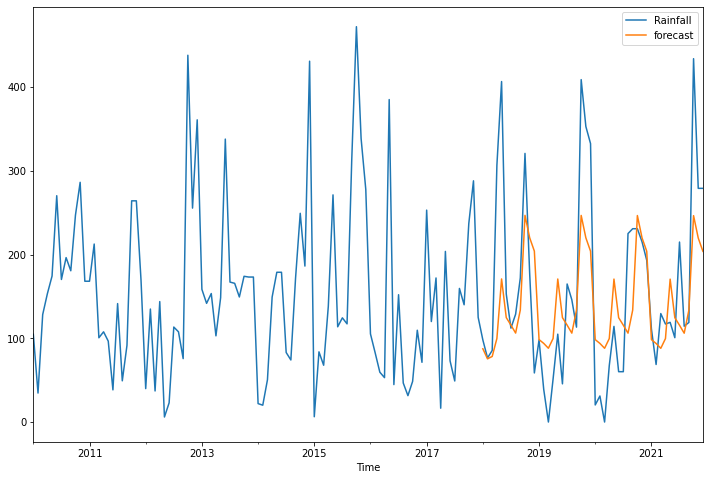

In [34]:
rain['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
rain[['Rainfall','forecast']].plot(figsize=(12,8))

In [30]:
rain.tail()

,Rainfall,forecast
Time,,
2021-08-01,114.400000,106.058913
2021-09-01,118.899999,133.559630
2021-10-01,433.799999,246.410822
2021-11-01,279.000003,219.699143
2021-12-01,279.000003,203.773999
